# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.04599453 -0.17947696  0.03578014  0.30031878] 0 1.0 False {}
state, action, reward, done, info
[-0.04958407  0.01511721  0.04178651  0.01913145] 1 1.0 False {}
state, action, reward, done, info
[-0.04928172  0.20961576  0.04216914 -0.26008004] 1 1.0 False {}
state, action, reward, done, info
[-0.04508941  0.01391799  0.03696754  0.04559971] 0 1.0 False {}
state, action, reward, done, info
[-0.04481105  0.20849088  0.03787953 -0.23519424] 1 1.0 False {}
state, action, reward, done, info
[-0.04064123  0.40305173  0.03317565 -0.51569224] 1 1.0 False {}
state, action, reward, done, info
[-0.0325802   0.59769118  0.0228618  -0.79773891] 1 1.0 False {}
state, action, reward, done, info
[-0.02062637  0.79249212  0.00690703 -1.08314318] 1 1.0 False {}
state, action, reward, done, info
[-0.00477653  0.98752224 -0.01475584 -1.37365073] 1 1.0 False {}
state, action, reward, done, info
[ 0.01497391  1.18282551 -0.04222885 -1.6709118 ] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.18282551039394 -1.6709117993079827


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # nextQs calculated using next_states and dones/end-of-episodes
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [7]:
# Generator: Generating the actions
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states, actions, nextQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # Masking the actions logits
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))
    #q_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(nextQs)))
    
    return actions_logits, q_loss

In [9]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [13]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 30000000           # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
batch_size = 2000              # memory capacity and experience mini-batch size

In [14]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    total_step = 0
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()

        # Take one random step to get the pole and cart moving
        action = env.action_space.sample()
        state, _, done, _ = env.step(action)
        reward = 1 - float(done)
        memory.buffer.append((action, state, reward))
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        loss = 0
        for _ in range(max_steps): # start=0, step=1, stop=max_steps
            
            # Explore or Exploit
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Sample mini-batch from memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])

            # Calculating nextQs
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)            
            actions_rewarded = np.multiply(actions_logits, rewards.reshape([-1, 1]))
            Qs = np.max(actions_rewarded, axis=1)

            # Updating the model: Calculating Qs ~= nextQs 
            feed_dict = {model.states: states[:-1], 
                         model.actions: actions[1:], 
                         model.nextQs: Qs[1:]}
            loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
        
            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Training q_loss: {:.4f}'.format(loss),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 12.0 Training q_loss: 0.0039 Explore P: 0.9987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 20.0 Training q_loss: 0.0040 Explore P: 0.9966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 15.0 Training q_loss: 0.0097 Explore P: 0.9951
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 17.0 Training q_loss: 0.0244 Explore P: 0.9933
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 36 Total reward: 36.0 Training q_loss: 3761.5730 Explore P: 0.9192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 16.0 Training q_loss: 4887.1738 Explore P: 0.9177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 14.0 Training q_loss: 5997.5752 Explore P: 0.9163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 27.0 Training q_loss: 9799.1338 Explore P: 0.9138
-------------------------------------------------------------------------------
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 48.0 Training q_loss: 14481370.0000 Explore P: 0.8535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 33.0 Training q_loss: 19242562.0000 Explore P: 0.8507
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 17.0 Training q_loss: 19440396.0000 Explore P: 0.8492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 12.0 Training q_loss: 21956328.0000 Explore P: 0.8481
-------------------------------------------------------------------------------
----------------------------------------

-------------------------------------------------------------------------------
Episode: 105 Total reward: 80.0 Training q_loss: 53268045824.0000 Explore P: 0.7615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 106 Total reward: 41.0 Training q_loss: 70475284480.0000 Explore P: 0.7583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 107 Total reward: 16.0 Training q_loss: 76947111936.0000 Explore P: 0.7570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 23.0 Training q_loss: 91303649280.0000 Explore P: 0.7552
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 139 Total reward: 32.0 Training q_loss: 41103604580352.0000 Explore P: 0.6340
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 50.0 Training q_loss: 44904944238592.0000 Explore P: 0.6308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 41.0 Training q_loss: 49963492966400.0000 Explore P: 0.6282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 82.0 Training q_loss: 54733242892288.0000 Explore P: 0.6231
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 172 Total reward: 198.0 Training q_loss: 3369351109410816.0000 Explore P: 0.4323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 173 Total reward: 104.0 Training q_loss: 3676860567257088.0000 Explore P: 0.4278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 174 Total reward: 198.0 Training q_loss: 3329649237032960.0000 Explore P: 0.4196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 175 Total reward: 175.0 Training q_loss: 2974254383497216.0000 Explore P: 0.4125
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 205 Total reward: 198.0 Training q_loss: 156529311350784.0000 Explore P: 0.2352
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 198.0 Training q_loss: 130290525667328.0000 Explore P: 0.2308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 207 Total reward: 198.0 Training q_loss: 103797875539968.0000 Explore P: 0.2264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 198.0 Training q_loss: 86115335798784.0000 Explore P: 0.2222
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 239 Total reward: 198.0 Training q_loss: 12581057069056.0000 Explore P: 0.1267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 198.0 Training q_loss: 12016306618368.0000 Explore P: 0.1244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 198.0 Training q_loss: 9422725185536.0000 Explore P: 0.1221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 198.0 Training q_loss: 6089743007744.0000 Explore P: 0.1199
-------------------------------------------------------------------------------
----------

Episode: 272 Total reward: 10.0 Training q_loss: 893138784747520.0000 Explore P: 0.1070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 273 Total reward: 10.0 Training q_loss: 937641423929344.0000 Explore P: 0.1069
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 274 Total reward: 10.0 Training q_loss: 961993955606528.0000 Explore P: 0.1068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 275 Total reward: 10.0 Training q_loss: 1003694329954304.0000 Explore P: 0.1067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode

-------------------------------------------------------------------------------
Episode: 306 Total reward: 193.0 Training q_loss: 697725221863424.0000 Explore P: 0.0963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 307 Total reward: 157.0 Training q_loss: 736663730913280.0000 Explore P: 0.0949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 308 Total reward: 145.0 Training q_loss: 867629631799296.0000 Explore P: 0.0937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 309 Total reward: 129.0 Training q_loss: 982991446736896.0000 Explore P: 0.0926
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 339 Total reward: 168.0 Training q_loss: 252427190140928.0000 Explore P: 0.0692
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 340 Total reward: 166.0 Training q_loss: 231348916715520.0000 Explore P: 0.0683
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 341 Total reward: 198.0 Training q_loss: 191708247621632.0000 Explore P: 0.0671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 342 Total reward: 196.0 Training q_loss: 166206661197824.0000 Explore P: 0.0660
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 372 Total reward: 198.0 Training q_loss: 2191279966388224.0000 Explore P: 0.0488
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 198.0 Training q_loss: 2079624238465024.0000 Explore P: 0.0480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 374 Total reward: 76.0 Training q_loss: 2030045820354560.0000 Explore P: 0.0477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 375 Total reward: 198.0 Training q_loss: 1862938843414528.0000 Explore P: 0.0470
-------------------------------------------------------------------------------
-

-------------------------------------------------------------------------------
Episode: 405 Total reward: 26.0 Training q_loss: 2899309083230208.0000 Explore P: 0.0398
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 406 Total reward: 21.0 Training q_loss: 2992027763474432.0000 Explore P: 0.0397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 407 Total reward: 22.0 Training q_loss: 3099942038011904.0000 Explore P: 0.0396
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 408 Total reward: 13.0 Training q_loss: 3205138671992832.0000 Explore P: 0.0396
-------------------------------------------------------------------------------
----

-------------------------------------------------------------------------------
Episode: 438 Total reward: 139.0 Training q_loss: 1447558463356928.0000 Explore P: 0.0350
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 142.0 Training q_loss: 1286774483582976.0000 Explore P: 0.0346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 145.0 Training q_loss: 1030681756958720.0000 Explore P: 0.0343
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 128.0 Training q_loss: 780251474952192.0000 Explore P: 0.0340
-------------------------------------------------------------------------------
-

-------------------------------------------------------------------------------
Episode: 471 Total reward: 198.0 Training q_loss: 77867295703040.0000 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 472 Total reward: 198.0 Training q_loss: 62733504479232.0000 Explore P: 0.0237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 473 Total reward: 198.0 Training q_loss: 51278226915328.0000 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 474 Total reward: 198.0 Training q_loss: 42758806962176.0000 Explore P: 0.0232
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 505 Total reward: 198.0 Training q_loss: 254118952960.0000 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 506 Total reward: 198.0 Training q_loss: 226013675520.0000 Explore P: 0.0170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 507 Total reward: 198.0 Training q_loss: 284516286464.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 508 Total reward: 198.0 Training q_loss: 221127852032.0000 Explore P: 0.0167
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 539 Total reward: 198.0 Training q_loss: 3232195411968.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 198.0 Training q_loss: 3224329519104.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 198.0 Training q_loss: 2966783000576.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 542 Total reward: 198.0 Training q_loss: 2765819215872.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 573 Total reward: 74.0 Training q_loss: 28923398193152.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 574 Total reward: 198.0 Training q_loss: 28684889096192.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 575 Total reward: 198.0 Training q_loss: 28617752969216.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 576 Total reward: 198.0 Training q_loss: 28220462202880.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 607 Total reward: 198.0 Training q_loss: 8424399044608.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 608 Total reward: 198.0 Training q_loss: 9150179311616.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 609 Total reward: 198.0 Training q_loss: 9170599280640.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 610 Total reward: 198.0 Training q_loss: 9756673572864.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 641 Total reward: 198.0 Training q_loss: 11158995075072.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 642 Total reward: 198.0 Training q_loss: 11331589636096.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 643 Total reward: 198.0 Training q_loss: 11840743538688.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 644 Total reward: 198.0 Training q_loss: 11968707559424.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 675 Total reward: 198.0 Training q_loss: 11022041612288.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 676 Total reward: 198.0 Training q_loss: 11251181682688.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 677 Total reward: 198.0 Training q_loss: 11455837503488.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 678 Total reward: 198.0 Training q_loss: 11310295154688.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 709 Total reward: 198.0 Training q_loss: 10235175501824.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 710 Total reward: 198.0 Training q_loss: 9373955915776.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 711 Total reward: 198.0 Training q_loss: 10170858995712.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 712 Total reward: 198.0 Training q_loss: 10165782839296.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 743 Total reward: 198.0 Training q_loss: 10033211375616.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 744 Total reward: 198.0 Training q_loss: 9550510948352.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 745 Total reward: 198.0 Training q_loss: 10486283239424.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 746 Total reward: 198.0 Training q_loss: 10796110184448.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 777 Total reward: 198.0 Training q_loss: 9818038337536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 778 Total reward: 198.0 Training q_loss: 10355817316352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 779 Total reward: 198.0 Training q_loss: 10587741356032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 780 Total reward: 198.0 Training q_loss: 10149250990080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 811 Total reward: 198.0 Training q_loss: 11379531579392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 812 Total reward: 198.0 Training q_loss: 11428394172416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 813 Total reward: 198.0 Training q_loss: 11531805786112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 814 Total reward: 198.0 Training q_loss: 11801669402624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 845 Total reward: 198.0 Training q_loss: 10438157795328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 846 Total reward: 198.0 Training q_loss: 9963893161984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 847 Total reward: 198.0 Training q_loss: 10400260161536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 848 Total reward: 198.0 Training q_loss: 10597637816320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 879 Total reward: 198.0 Training q_loss: 11549599072256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 880 Total reward: 198.0 Training q_loss: 11683380592640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 881 Total reward: 198.0 Training q_loss: 10849097875456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 882 Total reward: 198.0 Training q_loss: 10657950859264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 913 Total reward: 198.0 Training q_loss: 10814099554304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 914 Total reward: 198.0 Training q_loss: 10442539794432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 915 Total reward: 198.0 Training q_loss: 10649776160768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 916 Total reward: 198.0 Training q_loss: 10451892043776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 947 Total reward: 198.0 Training q_loss: 9668433805312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 948 Total reward: 198.0 Training q_loss: 10801500913664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 949 Total reward: 198.0 Training q_loss: 10165515452416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 950 Total reward: 198.0 Training q_loss: 10796357648384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 981 Total reward: 198.0 Training q_loss: 10274981543936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 982 Total reward: 198.0 Training q_loss: 10067453673472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 983 Total reward: 198.0 Training q_loss: 9813297725440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 984 Total reward: 198.0 Training q_loss: 9798626050048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

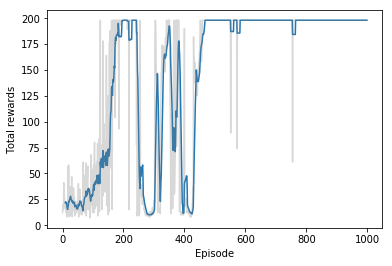

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

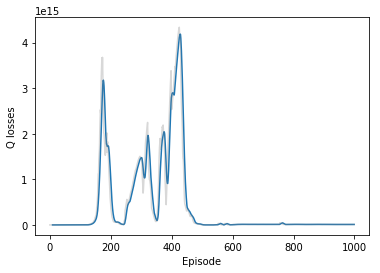

In [21]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:
    
    # Initialize/restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Take one random step to get the pole and cart moving
        env.reset()
        state, _, done, _ = env.step(env.action_space.sample())
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.